### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import PIL.Image as Image
from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thd
from tqdm import tqdm

### Set up data

In [2]:
class SubvolumeDataset(thd.Dataset):
    def __init__(
        self,
        fragments: List[Path],
        voxel_shape: Tuple[int, int, int],
        load_inklabels: bool = True,
        filter_edge_pixels: bool = False,
    ):
        self.fragments = sorted(map(lambda path: path.resolve(), fragments))
        self.voxel_shape = voxel_shape
        self.load_inklabels = load_inklabels
        self.filter_edge_pixels = filter_edge_pixels

        # Load sequentially
        labels = []
        image_stacks = []
        valid_pixels = []
        for fragment_id, fragment_path in enumerate(self.fragments):
            fragment_path = fragment_path.resolve()  # absolute path
            mask = np.array(Image.open(str(fragment_path / "mask.png")).convert("1"))

            surface_volume_paths = sorted(
                (fragment_path / "surface_volume").rglob("*.tif")
            )
            z_dim, y_dim, x_dim = voxel_shape

            z_mid = len(surface_volume_paths) // 2
            z_start, z_end = z_mid - z_dim // 2, z_mid + z_dim // 2

            # we don't convert to torch since it doesn't support uint16
            images = [
                np.array(Image.open(fn)) for fn in surface_volume_paths[z_start:z_end]
            ]
            image_stack = np.stack(images, axis=0)
            image_stacks.append(image_stack)

            pixels = np.stack(np.where(mask == 1), axis=1).astype(np.uint16)
            if filter_edge_pixels:
                height, width = mask.shape
                mask_y = np.logical_or(
                    pixels[:, 0] < y_dim // 2, pixels[:, 0] >= height - y_dim // 2
                )
                mask_x = np.logical_or(
                    pixels[:, 1] < x_dim // 2, pixels[:, 1] >= width - x_dim // 2
                )
                pixel_mask = np.logical_or(mask_y, mask_x)
                pixels = pixels[~pixel_mask]
            # encode fragment ID
            fragment_ids = np.full_like(pixels[:, 0:1], fragment_id)
            pixels = np.concatenate((pixels, fragment_ids), axis=1)
            valid_pixels.append(pixels)

            if load_inklabels:
                # binary mask can be stored as np.bool
                inklabels = (
                    np.array(Image.open(str(fragment_path / "inklabels.png"))) > 0
                )
                labels.append(inklabels)

            print(f"Loaded fragment {fragment_path} on {os.getpid()}")

        self.labels = labels
        self.image_stacks = image_stacks
        self.pixels = np.concatenate(valid_pixels).reshape(
            -1, valid_pixels[0].shape[-1]
        )

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        center_y, center_x, fragment_id = self.pixels[index]
        z_dim, y_dim, x_dim = self.voxel_shape
        image_stack = self.image_stacks[fragment_id]
        _, height, width = image_stack.shape

        # pad with zeros if necessary
        if (
            center_y < y_dim // 2
            or center_x < x_dim // 2
            or center_y + y_dim // 2 >= height
            or center_x + x_dim // 2 >= width
        ):
            # calculate the upper-left corner of the sub-volume
            y_start = max(center_y - y_dim // 2, 0)
            x_start = max(center_x - x_dim // 2, 0)

            # calculate the lower-right corner of the sub-volume
            y_end = min(center_y + y_dim // 2, height)
            x_end = min(center_x + x_dim // 2, width)

            subvolume = np.zeros(self.voxel_shape, dtype=np.float32)

            pad_y_start = max(y_dim // 2 - center_y, 0)
            pad_x_start = max(x_dim // 2 - center_x, 0)

            pad_y_end = min(height + y_dim // 2 - center_y, y_dim)
            pad_x_end = min(width + x_dim // 2 - center_x, x_dim)

            subvolume[:, pad_y_start:pad_y_end, pad_x_start:pad_x_end] = (
                image_stack[:, y_start:y_end, x_start:x_end].astype(np.float32) / 65535
            )

        else:
            subvolume = (
                image_stack[
                    :,
                    center_y - y_dim // 2 : center_y + y_dim // 2,
                    center_x - x_dim // 2 : center_x + x_dim // 2,
                ]
            ).astype(np.float32) / 65535
        if self.load_inklabels:
            inklabel = float(self.labels[fragment_id][center_y, center_x])
        else:
            inklabel = -1.0

        return torch.from_numpy(subvolume).unsqueeze(0), torch.FloatTensor([inklabel])

    def plot_label(self, index, **kwargs):
        pixel = self.pixels[index]
        label = self.labels[pixel[-1]]

        print("Index:", index)
        print("Pixel:", pixel)
        print("Label:", int(label[pixel[0], pixel[1]]))

        if isinstance(label, torch.Tensor):
            label = label.numpy()

        fig, ax = plt.subplots(**kwargs)
        ax.imshow(label, cmap="gray")

        y, x, _ = pixel
        _, y_dim, x_dim = self.voxel_shape
        x_min = x - (x_dim // 2)
        x_max = x + (x_dim // 2)
        y_min = y - (y_dim // 2)
        y_max = y + (y_dim // 2)

        rect = plt.Rectangle(
            (x_min, y_min), x_dim, y_dim, linewidth=2, edgecolor="y", facecolor="none"
        )
        ax.add_patch(rect)
        plt.show()

In [3]:
base_path = Path("/kaggle/input/vesuvius-challenge/")
train_path = base_path / "train"
all_fragments = sorted([f.name for f in train_path.iterdir()])
print("All fragments:", all_fragments)
# Due to limited memory on Kaggle, we can only load 1 full fragment
train_fragments = [train_path / fragment_name for fragment_name in ["1"]]
train_fragments

All fragments: ['1', '2', '3']


[PosixPath('/kaggle/input/vesuvius-challenge/train/1')]

In [4]:
%%time
train_dset = SubvolumeDataset(fragments=train_fragments, voxel_shape=(48, 64, 64), filter_edge_pixels=True)
print("Num items (pixels)", len(train_dset))

Loaded fragment /kaggle/input/vesuvius-challenge/train/1 on 24
Num items (pixels) 29135930
CPU times: user 6.86 s, sys: 13.4 s, total: 20.3 s
Wall time: 1min 9s


#### Sanity check 

Index: 6136130
Pixel: [1773 2999    0]
Label: 1


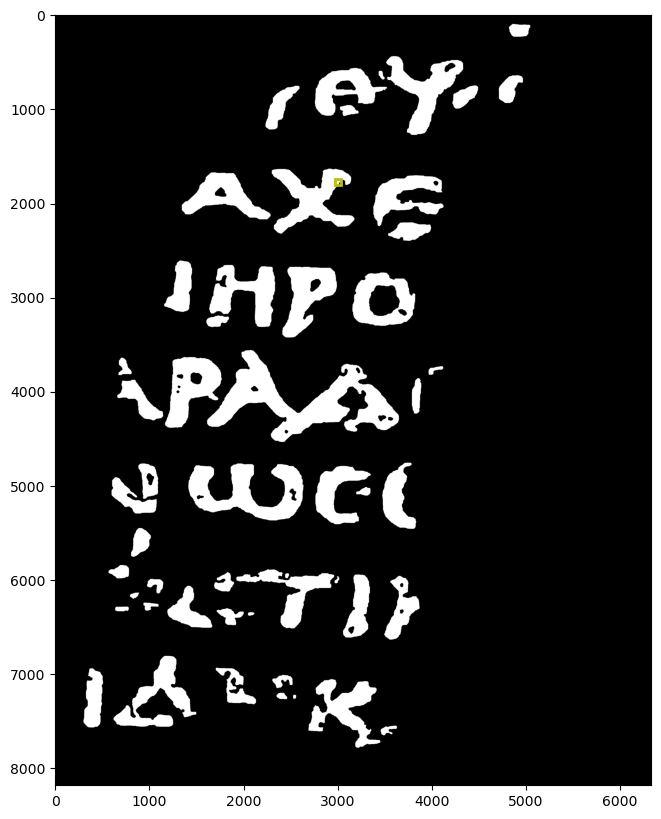

In [5]:
index = 6136130
train_dset.plot_label(index, figsize=(16, 10))

In [6]:
BATCH_SIZE = 32
train_loader = thd.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
print("Num batches:", len(train_loader))

Num batches: 910498


### Set up model

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [9]:
model = InkDetector().to(DEVICE)

### Train

In [10]:
TRAINING_STEPS = 60000
LEARNING_RATE = 1e-3
TRAIN_RUN = True # To avoid re-running when saving the notebook

In [11]:
warnings.simplefilter('ignore', UndefinedMetricWarning)

In [12]:
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, total_steps=TRAINING_STEPS)
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    running_fbeta = 0.0
    denom = 0
    pbar = tqdm(enumerate(train_loader), total=TRAINING_STEPS)
    for i, (subvolumes, inklabels) in pbar:
        if i >= TRAINING_STEPS:
            break
        optimizer.zero_grad()
        outputs = model(subvolumes.to(DEVICE))
        loss = criterion(outputs, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()
        scheduler.step()
        pred_ink = outputs.detach().sigmoid().gt(0.4).cpu().int()
        accuracy = (pred_ink == inklabels).sum().float().div(inklabels.size(0))
        running_fbeta += fbeta_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        running_accuracy += accuracy.item()
        running_loss += loss.item()
        denom += 1
        pbar.set_postfix({"Loss": running_loss / denom, "Accuracy": running_accuracy / denom, "Fbeta@0.5": running_fbeta / denom})
        if (i + 1) % 500 == 0:
            running_loss = 0.
            running_accuracy = 0.
            running_fbeta = 0.
            denom = 0

    torch.save(model.state_dict(), "/kaggle/working/model.pt")

else:
    model_weights = torch.load("/kaggle/working/model.pt")
    model.load_state_dict(model_weights)

100%|██████████| 60000/60000 [50:52<00:00, 19.66it/s, Loss=0.237, Accuracy=0.903, Fbeta@0.5=0.738]


### Evaluate

In [13]:
# Clear memory before loading test fragments
train_dset.labels = None
train_dset.image_stacks = []
del train_loader, train_dset
gc.collect()

3873

In [14]:
test_path = base_path / "test"
test_fragments = [train_path / fragment_name for fragment_name in test_path.iterdir()]
print("All fragments:", test_fragments)

All fragments: [PosixPath('/kaggle/input/vesuvius-challenge/test/b'), PosixPath('/kaggle/input/vesuvius-challenge/test/a')]


In [15]:
pred_images = []
model.eval()
for test_fragment in test_fragments:
    outputs = []
    eval_dset = SubvolumeDataset(fragments=[test_fragment], voxel_shape=(48, 64, 64), load_inklabels=False)
    eval_loader = thd.DataLoader(eval_dset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(tqdm(eval_loader)):
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    # we only load 1 fragment at a time
    image_shape = eval_dset.image_stacks[0].shape[1:]
    eval_dset.labels = None
    eval_dset.image_stacks = None
    del eval_loader
    gc.collect()

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x, _), prob in zip(eval_dset.pixels[:outputs.shape[0]], outputs):
        pred_image[y ,x] = prob > 0.4
    pred_images.append(pred_image)
    
    eval_dset.pixels = None
    del eval_dset
    gc.collect()
    print("Finished", test_fragment)

Loaded fragment /kaggle/input/vesuvius-challenge/test/b on 24


100%|██████████| 572623/572623 [3:52:45<00:00, 41.00it/s]


Finished /kaggle/input/vesuvius-challenge/test/b
Loaded fragment /kaggle/input/vesuvius-challenge/test/a on 24


100%|██████████| 338092/338092 [2:13:16<00:00, 42.28it/s]


Finished /kaggle/input/vesuvius-challenge/test/a


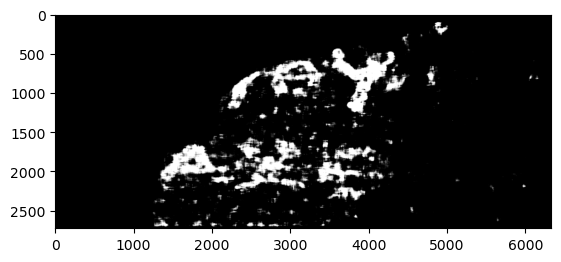

In [16]:
plt.imshow(pred_images[1], cmap='gray')

### Submission

In [17]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [18]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [19]:
pd.DataFrame.from_dict(submission)

,Id,Predicted
0,b,2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 ...
1,a,105 1 105 1 105 2 105 2 105 3 105 4 105 5 105 ...
